## Worksheet 8

### Group 22 Eaton Heidegger and Shannon Schröder

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import riemann_exact as riemann

### Computational Fluid Mechanics I
 ####  Non-linear advection: FD vs. FV

a) i) The solution at x/t can be written in the case of the shock forming situation ($u_L > u_R$) as : 

![image.png](./image.png)


![Screenshot 2025-05-20 114057.png](./burgersShock.png)

In general, in case of a shock, the left side is moving faster than the right, as given above: $u_L > u_R$. Therefore, characteristics converge, since each characteristic travels as speed u (and the left side is faster than the right) and the wavefronts 'crash' into each other. This leads to a formation of a shock, i.e. a discontinous jump in the solution. 


The conservation law in conservative form gives us the Rankine-Hugoniot jump condition across a shock moving at speed s:

$ s = \frac{f(u_L)-f(u_R)}{u_L-u_R} = \frac{1/2 u^2_L -1/2 u^2_R}{u_L-u_R} = \frac{u_L + u_R}{2} $

The Lax entropy condition $u_L > s > u_R$ selects the physical branch, so the self-similar solution is the two constant states separated by a shock moving at speed s:

Graphically, on the left plot, we can see that the line x = st splits the x-t diagram into two sections. To the left of the line $u=u_L$ and to the right $u = u_R$ 

On the right plot, we can see the discontinuity jump of the shock solution. On the left, we have $u_L = 1$ and then the shock line at x/t - $\zeta$ , which is the similarity variable. This is the graph of the self-similar solution $u= u(\zeta)$ against $\zeta = x/t$. The step is located at $\zeta = s$.

(We can check this with the flux a x=0, t=0.  Since the shock speed is s, we have to check wheter $0<s$  or larger s. At x=0, if $s>0$, then u(0,1) = $u_L$. If $s<0$, then u(0,1) = $u_R$.)


a) ii) The solution can be written in the case of rarefaction wave as: 

![u(x,t)](./u_rarefaction.png)

with the flux location x=0 given by f(u(0,1))

![Screenshot 2025-05-20 114103.png](./BurgersRarefaction.png)

In the Rarefaction case, the left side moves faster than the right: $u_L < u_R$. The characteristic is spread out, as we can see in the left plot. The flow 'stretches', leading to a rarefaction wave. The solution therefore smootly interpolates bewteen $u_L$ and $u_R$. ( In other words the characteristics diverge and leave a gap that must be filled by the continuous branch!) 


If we apply the method of characteristics for burgers equation :

$\frac{dx}{dt} = u(x,t)$

The initial condition is discontinous, so we assume a self-similar solution: 

$u(x,t) = u(\zeta)$, where $\zeta = \frac{x}{t}$ (as in plot of i))

We insert this into the conseervative form from the exercise sheet: 

$\delta_t u + \delta_x f(u) = 0$, with $f(u) = \frac{1}{2} u^2$, 

we get: 

$\delta_t u + \delta_x \left(\frac{1}{2}u^2 \right) = 0 
\rightarrow - \frac{\zeta}{t}u'(\zeta) + \frac{1}{t} u(\zeta) u'(\zeta) = 0 
\rightarrow u'(\zeta) (-\zeta + u(\zeta)) = 0 $

**This gets us a gap that must be filled by the continous branch: $u(\zeta) = \zeta$**


Therefore the solution is  within the fan as above: 

$u(x,t) = \frac{x}{t}$, for $u_L < \frac{x}{t} < u_R$ Which then yields the above solution : a continous profile


The fan occupies the sector bounded by the two extreme characteristic speeds 
uL and uR (left plot). On the right plot, there is an alternative 'shock' with uL < uR which would violate the entropy condition and is therefore inadmissible. 
 

#### b i) Use the supplied notebook burgers fvm.ipynb and implement the missing flux functions for the finite volume method based on the solution to the Riemann problem given in a) for x ∈[0,1].

Finite Volume Method: 
- Integrated the conservation law over each cell
- requires numerical fluxes at cell interfaces to update the cell-averaged values 

The idea is that for a finite-volume interface we need the exact flux that crosses the line x = 0 during the time step. Because the solution of the Riemann poblem is self-similar, all that matters is the value it takes at the similarity point $\zeta = \frac{x}{t} = 0 = u $.

The exact numerical flux is then simply $F = f(u) = \frac{1}{2} u^2$
Therefore to compute the numerical flux at an interface, we solve the Rieman problem, by evaluating u(0,1), which is the state at the interface after a unit time and compute the flux f(u(0,1)).


We have:
1. the shock, here u(x,t) =$u_L$, if x/t < s, $u_R$ otherwise, with s = ($u_L +u_R / 2$). Therefore, we have for the shock ($u_L > u_R$):
- if s > 0 (>$\zeta =0$) : u = $u_L$

2. Rarefaction (if $u_L < u_R$), at x0, which gives us: 

- u(0,t) = $u_L$, if $u_L > 0  $ (left)
- u(0,t) = $u_R$, if $u_R < 0 $ (right)
- u(0,t) = 0, if $u_L \leq 0 \leq u_R $ (middle)


In [2]:
# Flux function
def flux(u):
    return 0.5 * u**2

# Riemann solver (Godunov flux for Burgers' equation)
def godunov_flux(uL, uR):
    if uL > uR:
        # Shock
        s = 0.5 * (uL + uR)
        u = uL if s > 0 else uR
        
        return flux(u)
    else:
        # Rarefaction
        if uL > 0: 
            u = uL
        elif uR < 0:
            u = uR  
        else:
            u = 0.0 
        return flux(u)

# Initial condition: step function
def initial_condition(x, uL, uR):
    return np.where(x < 0.5, uL, uR)

# Finite volume solver
def burgers_fvm(uL, uR, N=100, CFL=0.9, T=0.3):
    x = np.linspace(0, 1, N)
    dx = x[1] - x[0]
    u = initial_condition(x, uL, uR)
    
    t = 0.0
    while t < T:
        # Compute max speed for CFL condition
        max_speed = np.max(np.abs(u))
        dt = CFL * dx / max_speed 
        if t + dt > T:
            dt = T - t

        # Compute numerical fluxes
        fluxes = np.zeros(N+1)
        for i in range(1, N):
            fluxes[i] = godunov_flux(u[i-1], u[i])

        # Update solution
        u[1:-1] -= dt/dx * (fluxes[2:-1] - fluxes[1:-2])


        t += dt
        #print(f"Time: {t:.2f}, dt: {dt:.4f}")


    return x, u

ii) Plot the solution for the case of a shock wave and a rarefaction wave: (1) showing u as a function of x at a few select times

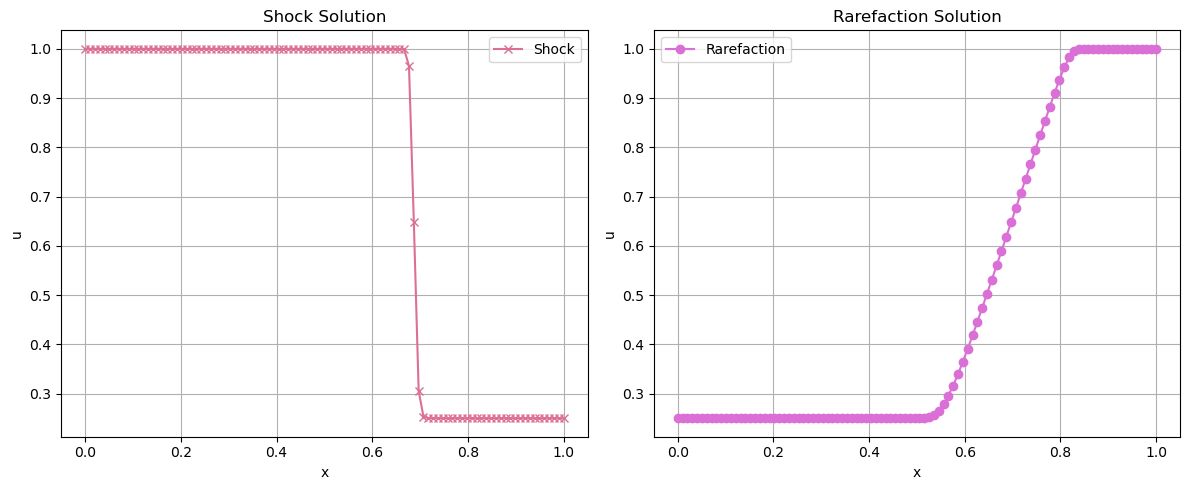

In [3]:
# Setup parameters : 
T = 0.3
N = 100

# Shock wave initial condition
uLs = 1.0
uRs = 0.25
xs, us = burgers_fvm(uLs, uRs, N=100)

# Rarefaction wave initial condition
uLr = 0.25
uRr = 1
xR, uR = burgers_fvm(uLr, uRr, N=100)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(xs, us, 'x-', label='Shock', color='palevioletred')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Shock Solution')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(xR, uR, 'o-',label='Rarefaction', color='orchid')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Rarefaction Solution')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

Left plot: 
We see the sharp discontinuity where where the shock is and the left side faster than the right.

Right plot: 
We see first the left side slower than the right and a more continous rise, where the fan is. 

 iii) Plot the solution for the case of a shock wave and a rarefaction wave:showing the full space-time diagram of the solution, i.e. as an image with t on the x-axis and x on the y-axis, and the colour indicating the value of u. 

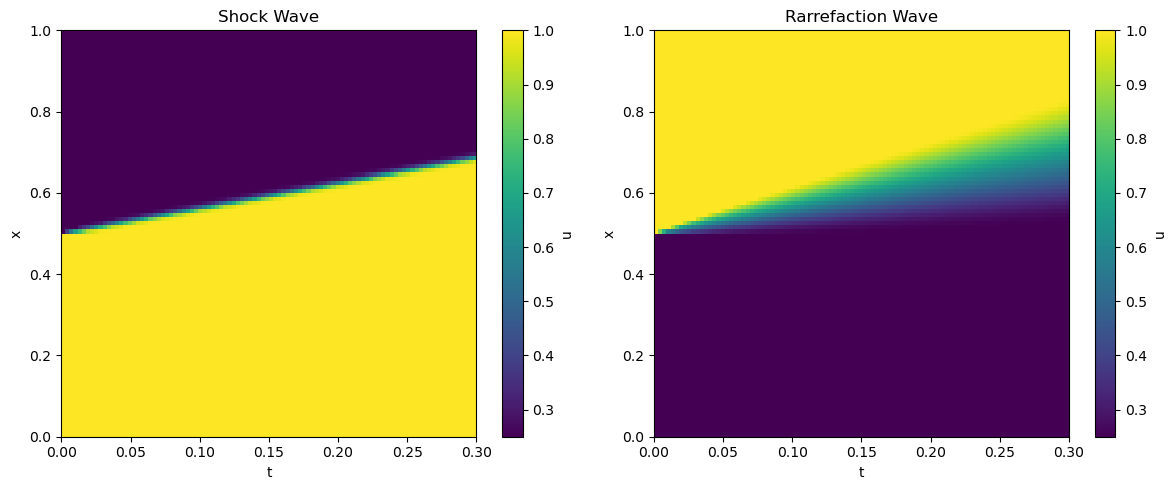

In [4]:
t = np.linspace(0, T, N)

u_space_time_S = np.zeros((N, N))
u_space_time_R = np.zeros((N, N))
for j in range(N):
    u_space_time_S[:, j] = burgers_fvm(uLs, uRs, N=N, T=t[j])[1]
    u_space_time_R[:, j] = burgers_fvm(uLr, uRr, N=N, T=t[j])[1]


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(u_space_time_S, extent=[t[0], t[-1], xs[0], xs[-1]], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='u')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Shock Wave')


plt.subplot(1, 2, 2)
plt.imshow(u_space_time_R, extent=[t[0], t[-1], xR[0], xR[-1]], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='u')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Rarrefaction Wave')
plt.tight_layout()
plt.show()

In the left panel, the transition is sharp and the scheme captures the shock clearly, as we would expect it.
In the right panel, we see the diffuse transition region, as predicted by the Rarrefaction case, where u smootly transitions from left to right value.

 ### 2. Full hydro equations in 1D– Shock tubes and a supernova explosion

ai)  Compute solutions to the following three Riemann problems with the  initial conditions and final times for $\gamma = 1.4$ (air)

In [5]:
def prim_to_cons(Q, gamma ):
    """
    Return an array of conserved hydro variables given an array of primitive variables
    @param Q : primitive variables (Nx3: rho, v, P)
    @return U: conserved variables (Nx3: rho, rhov, E)
    """
    U = np.zeros_like(Q)
    U[:,0] = Q[:,0]
    U[:,1] = Q[:,0] * Q[:,1]
    U[:,2] = Q[:,2]/(gamma-1) + 0.5 * Q[:,0] * Q[:,1]**2
    return U

def cons_to_prim(U, gamma ):
    """
    Return an array of primitive hydro variables given an array of conserved variables
    @return Q : primitive variables (Nx3: rho, v, P)
    @param U: conserved variables (Nx3: rho, rhov, E)
    """
    Q = np.zeros_like(U)
    Q[:,0] = U[:,0]
    Q[:,1] = U[:,1]/U[:,0]
    Q[:,2] = (gamma-1)*(U[:,2] - 0.5 *U[...,1]**2/U[...,0])
    return Q

def get_flux_from_U( U, gamma ):
    """
    Compute the flux vector from the conserved variables.
    @param U: Conserved variables (Nx3: rho, rhov, E)
    @param gamma: Adiabatic index
    @return F: Flux vector (Nx3: rho*v, rhov*v + P, (E+P)*v)
    """
    F = np.zeros_like(U)
    P = (gamma-1) * (U[:,2] - 0.5 * U[:,1]**2 / U[:,0])
    v = U[:,1] / U[:,0]
    F[:,0] = U[:,0] * v
    F[:,1] = U[:,1] * v + P
    F[:,2] = (U[:,2]+P) * v
    return F

def get_cs_and_v_from_U( U, gamma ):
    """
    Compute the sound speed and velocity from conserved variables.
    @param U: Conserved variables (Nx3: rho, rhov, E)
    @param gamma: Adiabatic index
    @return cs: Sound speed
    @return v: Velocity
    """
    v = U[:,1] / U[:,0]
    cs = np.sqrt( gamma*(gamma-1)*(U[:,2]/U[:,0]-0.5*v**2) )
    return cs, v

In [6]:
def get_conservative_update( U, dx, gamma, CFLfac ):
    """
    Compute the conservative update vector and the maximum allowed time step. Assumes periodic BCs.
    This function uses the HLL (Harten-Lax-van Leer) Riemann solver to compute the fluxes.

    Parameters:
    U (numpy.ndarray): Conserved variables (Nx3: rho, rhov, E).
    dx (float): Spatial resolution (cell width).
    gamma (float): Adiabatic index.
    CFLfac (float): CFL factor for time step calculation.

    Returns:
    dU (numpy.ndarray): Update vector for conserved variables (Nx3).
    dtmax (float): Maximum allowed time step based on CFL condition.
    """
    # compute the maximal allowed time step
    cs,v = get_cs_and_v_from_U( U, gamma )
    dtmax = CFLfac * dx / np.max( (np.abs(v)+np.abs(cs)).flatten() )

    # compute left and right state (piecewise constant approx.)
    # assume periodic BCs here, we'll fix this later in case we need
    # to use non-periodic BCs
    Uleft = U                     # U_L = U_i
    Uright = np.roll(U,-1,axis=0) # U_R = U_{i+1}

    # compute left and right flux from left and right states
    # assume periodic BCs here
    Fleft = get_flux_from_U( Uleft, gamma )   # Fleft = F( U_L )
    Fright = get_flux_from_U( Uright, gamma ) # Fright = F( U_R )

    # compute maximum signal speeds
    Sleft = np.abs(v) + np.abs(cs)
    Sright = np.roll(Sleft,-1)
    Sstar = np.max((Sleft,Sright))

    # compute HLL interface flux
    FHLL = np.zeros_like(U)
    for i in range(3): # loop over conserved variables
        FHLL[:,i] = 0.5*(Fleft[:,i]+Fright[:,i])-0.5 * Sstar * (Uright[:,i]-Uleft[:,i])

    # compute net flux in and out of cell due to left and right boundary
    dU = -( FHLL - np.roll(FHLL,+1,axis=0)) / dx

    return dU, dtmax

In [7]:
def solve_hydro1D( Q_ini, tend, gamma = 5/3, CFLfac = 0.95):
    """
    Solve the 1D hydrodynamics equations using the Godunov method with the HLL Riemann solver.

    Parameters:
    Q_ini (numpy.ndarray): Initial conditions for the primitive variables (Nx3: rho, v, P).
    tend (float): End time for the simulation.
    gamma (float, optional): Adiabatic exponent. Default is 5/3.
    CFLfac (float, optional): CFL factor for time step calculation. Default is 0.95.

    Returns:
    numpy.ndarray: Final primitive variables (Nx3: rho, v, P) at time `tend`.
    """
    
    N = Q_ini.shape[0]
    dx = 1/N
    U = prim_to_cons(Q_ini, gamma) # convert to conserved variables

    t = 0.0 # time counter
    step = 0 # step counter
    exceeded = False
    while t<tend:
        # compute the update vector for the primitive variables
        dU, dtmax = get_conservative_update(U, dx, gamma, CFLfac)

        # we use constant Dirichlet BCs, so we set the first and last flux to zero
        dU[0,:] = 0
        dU[-1,:] = 0
        
        # compute the time step we will use for this step
        dt = np.min((CFLfac*dtmax, tend-t))
            
        # actually perform the update
        U += dt*dU
        t += dt
        step += 1
        print('Step %i, t = %.2f, dt = %.2f' % (step, t, dt), end='\r')

    print('\n Done in %i steps'%step)
    return cons_to_prim(U, gamma) # return primitive variables

We will now for each given Riemann problem, define the initial conditions and run them through the solve_hydro1D and the riemann.solve_riemann_exact functions.

Each Riemann problem defines a discontinuity at $x=0.5$, with different left and right states for density $\rho$, velocity $v$ and pressure $P$. We then initilize these conditions for a 1D hydrodynamics simulation by setting up the primitive variables (density, velocity, and pressure) across the spatial domain.

Problem 1 



In [8]:
# define initial conditions
Np = 256
rho_L1 = 1.0
rho_R1 = 0.125
v_L1 = 0.0
v_R1 = 0.0
P_L1 = 1.0
P_R1 = 0.1
t_end1 = 0.25

x = np.linspace(0,1,Np)
Q_ini_1 = np.zeros((x.shape[0],3))
Q_ini_1[:,0] = np.where(x<0.5, rho_L1, rho_R1) # density
Q_ini_1[:,1] = np.where(x<0.5, v_L1, v_R1) # velocity
Q_ini_1[:,2] = np.where(x<0.5, P_L1, P_R1 ) # pressure

Now we are using the numerical solver to evolve the system until the final time t_end.

In [9]:
# Compute the solution
Q1 = solve_hydro1D( Q_ini_1, t_end1, gamma=1.4, CFLfac=0.95)

Step 154, t = 0.25, dt = 0.00
 Done in 154 steps


In [10]:
sol1 = riemann.solve_riemann_exact( left_state=(rho_L1, v_L1, P_L1), right_state=(rho_R1, v_R1, P_R1), gamma=1.4, t=t_end1, npts = 1000)

This gives the true solution to the Riemann problem, assuming no numerical diffusion.

Problem 2:

In [11]:
Np = 256
rho_L2 = 1.0
rho_R2 = 1.0
v_L2 = -2.0
v_R2 = 2.0
P_L2 = 0.4
P_R2 = 0.4
t_end2 = 0.15

x = np.linspace(0, 1, Np)
Q_ini_2 = np.zeros((x.shape[0], 3))
Q_ini_2[:,0] = np.where(x < 0.5, rho_L2, rho_R2)
Q_ini_2[:,1] = np.where(x < 0.5, v_L2, v_R2)
Q_ini_2[:,2] = np.where(x < 0.5, P_L2, P_R2)

In [12]:
Q2 = solve_hydro1D(Q_ini_2, t_end2, gamma=1.4, CFLfac=0.95)

Step 117, t = 0.15, dt = 0.00
 Done in 117 steps


In [13]:
sol2 = riemann.solve_riemann_exact( left_state=(rho_L2, v_L2, P_L2), right_state=(rho_R2, v_R2, P_R2), gamma=1.4, t=t_end2, npts = 1000)

Problem 3:

In [14]:
Np = 256
rho_L3 = 1.0
rho_R3 = 1.0
v_L3 = 0.0
v_R3 = 0.0
P_L3 = 1000.0
P_R3 = 0.01
t_end3 = 0.012

x = np.linspace(0, 1, Np)
Q_ini_3 = np.zeros((x.shape[0], 3))
Q_ini_3[:,0] = np.where(x < 0.5, rho_L3, rho_R3)
Q_ini_3[:,1] = np.where(x < 0.5, v_L3, v_R3)
Q_ini_3[:,2] = np.where(x < 0.5, P_L3, P_R3)

In [15]:
Q3 = solve_hydro1D(Q_ini_3, t_end3, gamma=1.4, CFLfac=0.95)

Step 179, t = 0.01, dt = 0.00
 Done in 179 steps


In [16]:
sol3 = riemann.solve_riemann_exact( left_state=(rho_L3, v_L3, P_L3), right_state=(rho_R3, v_R3, P_R3), gamma=1.4, t=t_end3, npts = 1000)

ii)  Make plots comparing the exact solution to your numerical solution at the final time in each of the three primitive variables

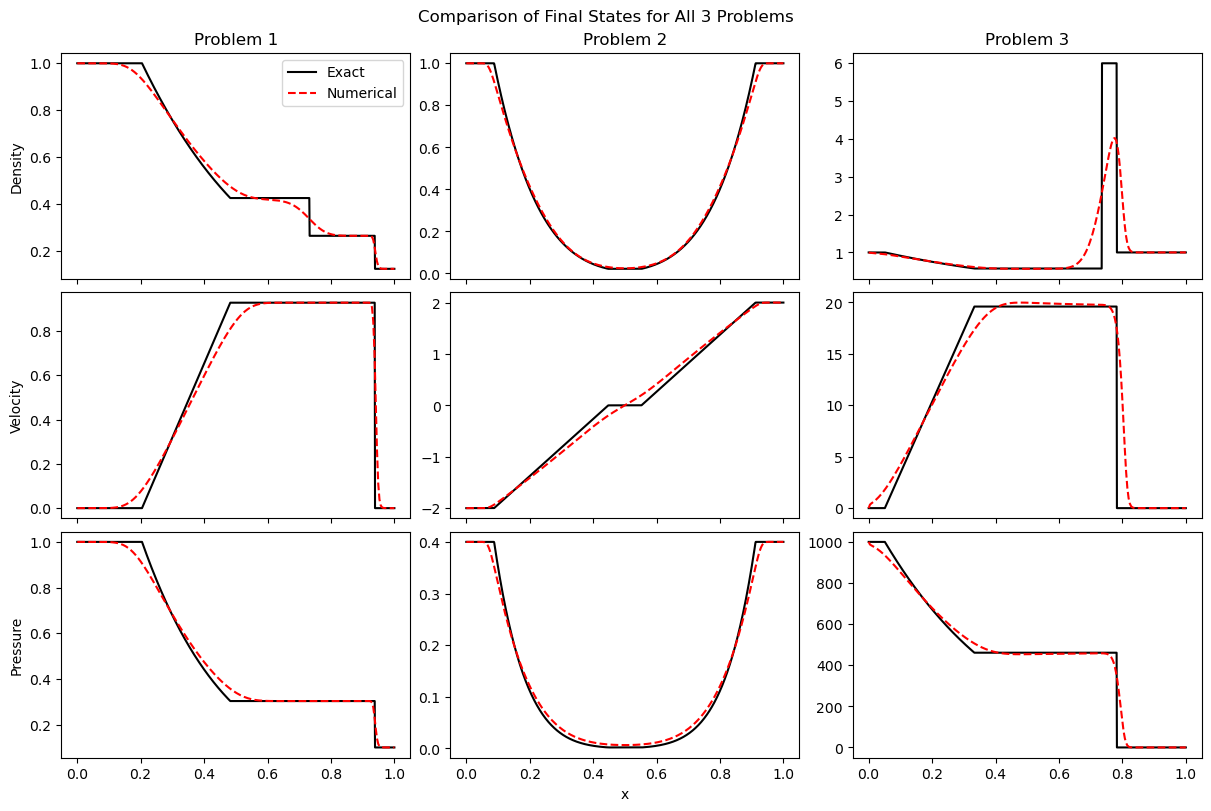

In [17]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8), sharex=True, layout='constrained')

problem_titles = ['Problem 1', 'Problem 2', 'Problem 3']

for i, (Q, sol, title) in enumerate(zip(
    [Q1, Q2, Q3],
    [sol1, sol2, sol3],
    problem_titles
)):
    axes[0, i].plot(sol['x'], sol['rho'], 'k-', label='Exact')
    axes[0, i].plot(x, Q[:,0], 'r--', label='Numerical')
    axes[0, i].set_title(title)
    if i == 0: axes[0, i].set_ylabel('Density')

    axes[1, i].plot(sol['x'], sol['v'], 'k-')
    axes[1, i].plot(x, Q[:,1], 'r--')
    if i == 0: axes[1, i].set_ylabel('Velocity')

    axes[2, i].plot(sol['x'], sol['P'], 'k-')
    axes[2, i].plot(x, Q[:,2], 'r--')
    if i == 0: axes[2, i].set_ylabel('Pressure')

axes[2, 1].set_xlabel('x')
axes[0, 0].legend()
plt.suptitle('Comparison of Final States for All 3 Problems')
plt.show()

iii) Show a space-time diagram of the numerical solution over the time span $[0,t_{end}]$ for each of the three problems.

In [18]:
def solve_hydro1D_spacetime(Q_ini, tend, gamma=5/3, CFLfac=0.95, store_history=False):
    N = Q_ini.shape[0]
    dx = 1 / N
    U = prim_to_cons(Q_ini, gamma)

    t = 0.0
    step = 0

    if store_history:
        Q_history = [Q_ini.copy()]
        t_history = [0.0]

    while t < tend:
        dU, dtmax = get_conservative_update(U, dx, gamma, CFLfac)
        dU[0, :] = 0
        dU[-1, :] = 0
        dt = min(CFLfac * dtmax, tend - t)

        U += dt * dU
        t += dt
        step += 1

        if store_history:
            Q = cons_to_prim(U, gamma)
            Q_history.append(Q.copy())
            t_history.append(t)

        print(f"Step {step}, t = {t:.3f}, dt = {dt:.4f}", end="\r")

    print(f"\n Done in {step} steps")

    if store_history:
        return cons_to_prim(U, gamma), np.array(Q_history), np.array(t_history)
    else:
        return cons_to_prim(U, gamma)

In the solve_hydro1D function, we added the the possibility to store the history of $Q$ and $t$ if we wanted with a boolean flag that controls wether to track the time evolution of the solution. If true, the solver then stores snapshots of the state at each time step. For that we convert the current conservative state $U$ back to $Q$ and append it. The solution is sampled after every update.

In [19]:
Q1, Qhist1, thist1 = solve_hydro1D_spacetime(Q_ini_1, t_end1, gamma=1.4, store_history=True)
Q2, Qhist2, thist2 = solve_hydro1D_spacetime(Q_ini_2, t_end2, gamma=1.4, store_history=True)
Q3, Qhist3, thist3 = solve_hydro1D_spacetime(Q_ini_3, t_end3, gamma=1.4, store_history=True)

Step 154, t = 0.250, dt = 0.0003
 Done in 154 steps
Step 117, t = 0.150, dt = 0.0012
 Done in 117 steps
Step 179, t = 0.012, dt = 0.0000
 Done in 179 steps


In [32]:
def plot_spacetime_all_vars(Q_hist, t_hist, title):
    labels = ['Density', 'Velocity', 'Pressure']
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
    for i, ax in enumerate(axes):
        im = ax.imshow(
            Q_hist[:, :, i].T,  # Transpose to make x vertical and t horizontal
            extent=[t_hist[0], t_hist[-1], 0, 1],  # [t_min, t_max, x_min, x_max],
            aspect='auto',
            cmap='viridis'
        )
        ax.set_title(labels[i])
        ax.set_xlabel('Time')
        if i == 0:
            ax.set_ylabel('x')
        fig.colorbar(im, ax=ax, label=labels[i])
    plt.suptitle(title)
    plt.tight_layout(pad=2.0)
    plt.show()

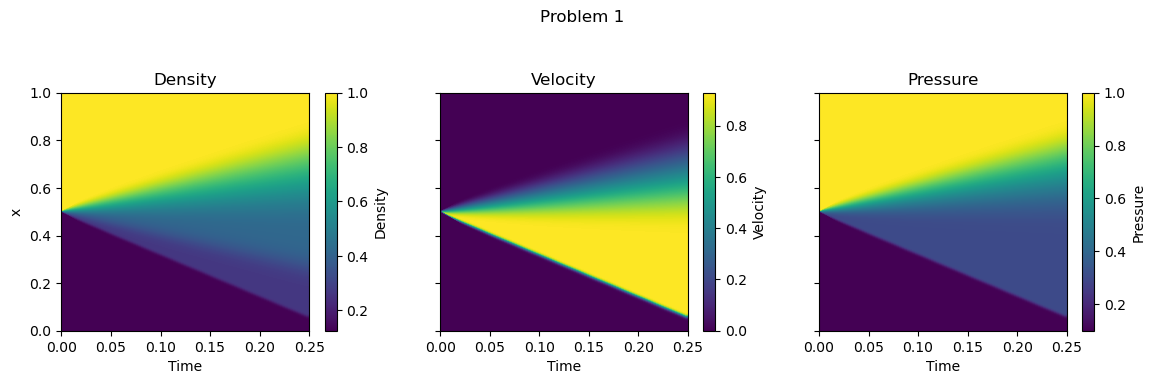

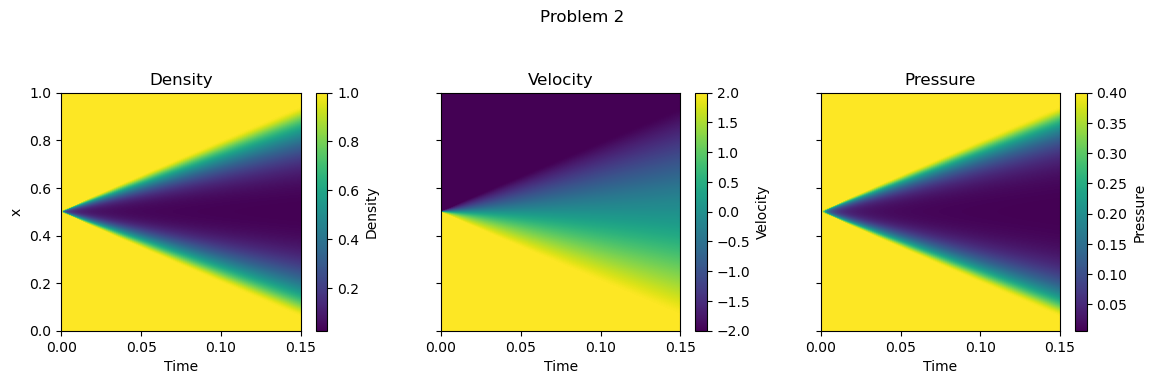

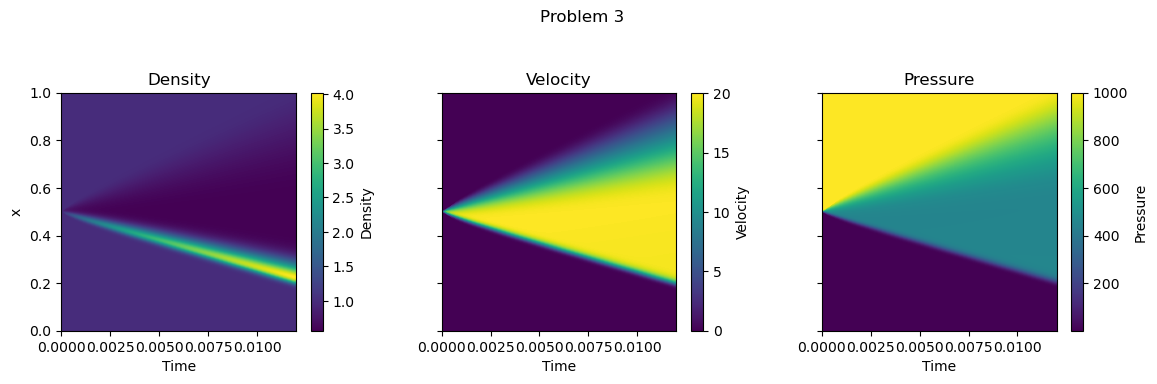

In [33]:
plot_spacetime_all_vars(Qhist1, thist1, title='Problem 1')
plot_spacetime_all_vars(Qhist2, thist2, title='Problem 2')
plot_spacetime_all_vars(Qhist3, thist3, title='Problem 3')

iv)  Explain the differences
 between the three problems and how they are reflected in the solution. Can you identify
 the different wave structures (shock waves, rarefaction fans, contact discontinuities) in the
 solution?

For problem 1 the initial conditions on the left side are a high density and pressure while on the right side the density and the pressure are low with zero velocity on both sides. The wave structure resembles a left moving rarefaction fan with right moving shock. In the center a contact discontinuity is visible for the density and velocity but not for the pressure. A clear three-part wave structure in both the final state and the space-time plot can be seen. The contact discontinuity moves to the right, while the rarefaction fan spreads leftward. The space-time plot shows smooth gradients (for rarefaction) and sharp discontinuities (shock, contact).

For problem 2 the initial conditions are a symmetric inward moving flow with the same speed. the pressure and density is the same for both sides. The structure of the wave resembles a two symmetric shocks propagating outward, with a high-density, high-pressure stagnation region in the center. No rarefaction fans can be seen. A sharp central compression zone (visible as a vertical column in space-time diagram) can be seen. Outward moving shock waves evident in all three primitive variables can be seen.

For problem 3 the initial conditions are a high pressure at the center, with same density and velocity on both sides. The wave structure resembles a strong right-moving shock with left moving rarefaction with a contact discontinuity between shock and rarefaction. An extreme pressure nd velocity contrast (note the vertical scale difference) can be observed. The space-time plot shows a rapid shock propagation to the right, and slower rarefaction to the left. The sharp gradients require fine spatial and temporal resolution.


b) Advection test

First we need to change the solve_hydro1D function. We comment out the lines setting Dirichlet BCs, as the solver would overwrite the boundaries with Dirichlet conditions. We then implement periodic boundary conditions by copying data from the right edge to the left ghost cells and vice versa.

In [34]:
def solve_hydro1D_spacetime_periodic(Q_ini, tend, gamma=5/3, CFLfac=0.95, store_history=False):
    N = Q_ini.shape[0]
    dx = 1 / N
    U = prim_to_cons(Q_ini, gamma)

    t = 0.0
    step = 0

    if store_history:
        Q_history = [Q_ini.copy()]
        t_history = [0.0]

    while t < tend:
        # Apply periodic BC:
        U[0, :] = U[-2, :]  # left ghost cell = last interior cell
        U[-1, :] = U[1, :]  # right ghost cell = first interior cell

        dU, dtmax = get_conservative_update(U, dx, gamma, CFLfac)

        # Remove these lines to allow periodic BC:
        # dU[0, :] = 0
        # dU[-1, :] = 0

        dt = min(CFLfac * dtmax, tend - t)

        U += dt * dU
        t += dt
        step += 1

        if store_history:
            Q = cons_to_prim(U, gamma)
            Q_history.append(Q.copy())
            t_history.append(t)

        print(f"Step {step}, t = {t:.3f}, dt = {dt:.4f}", end="\r")

    print(f"\n Done in {step} steps")

    if store_history:
        return cons_to_prim(U, gamma), np.array(Q_history), np.array(t_history)
    else:
        return cons_to_prim(U, gamma)


We then set new initial condtions for the advection test with a sinusoidal density perturbation

$\rho = 1 + \sin(2\pi x)/2$,

constant velocity $v=1$ and constant pressure $P=0.1$.

In [35]:
Np = 256
x = np.linspace(0, 1, Np, endpoint=False)  # periodic domain [0,1)
rho_init = 1 + 0.5 * np.sin(2 * np.pi * x)
v_init = np.ones_like(x)
P_init = 0.1 * np.ones_like(x)

Q_ini = np.zeros((Np, 3))
Q_ini[:, 0] = rho_init
Q_ini[:, 1] = v_init
Q_ini[:, 2] = P_init

We then run our updated solver with these conditions and at $t=1$.

In [36]:
t_end = 1.0
Q_final, Q_history, t_history = solve_hydro1D_spacetime_periodic(Q_ini, t_end, gamma=1.4, CFLfac=0.5, store_history=True)

Step 1553, t = 1.000, dt = 0.0005
 Done in 1553 steps


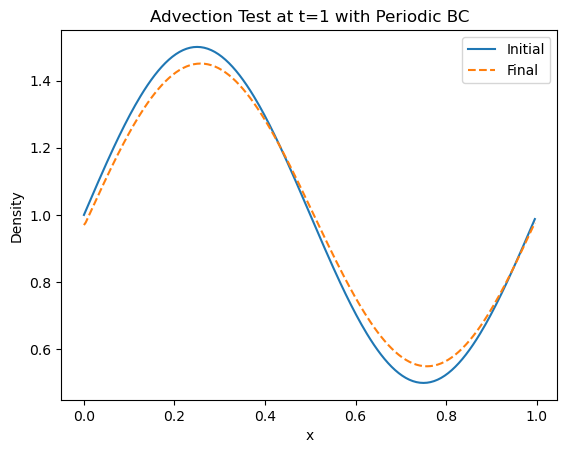

In [37]:
plt.plot(x, Q_ini[:,0], label='Initial')
plt.plot(x, Q_final[:,0], '--', label='Final')
plt.legend()
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Advection Test at t=1 with Periodic BC')
plt.show()

In the plot we can see for the advection test for the initial stage $(t=0)$ and the final stage $(t=1)$. Because velocity is constant and pressure uniform, no waves other than pure advection occur. The density wave should have shifted by exactly one domain lenght at $t=1$ and should look identical to the wave at the initial condition. However it doesnt, due to numercial diffusion, the wave is slightly shifted. 

Next we plot the solution curves for the density $\rho$, the velocity $v$ and the pressure $P$ at various times $(0.0, 0.25, 0.5, 0.75, 1.0)$.

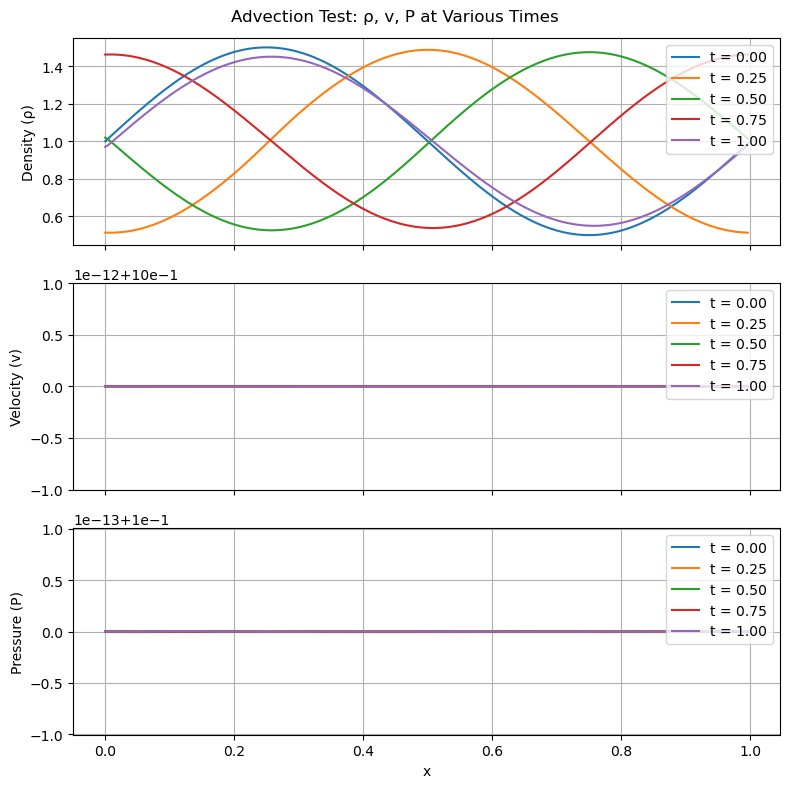

In [38]:
times_to_plot = [0.0, 0.25, 0.5, 0.75, 1.0]
snapshot_indices = [np.argmin(np.abs(np.array(t_history) - t)) for t in times_to_plot]

fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

for idx in snapshot_indices:
    label = f't = {t_history[idx]:.2f}'
    axs[0].plot(x, Q_history[idx][:, 0], label=label)  # Density
    axs[1].plot(x, Q_history[idx][:, 1], label=label)  # Velocity
    axs[2].plot(x, Q_history[idx][:, 2], label=label)  # Pressure

axs[0].set_ylabel('Density (ρ)')
axs[1].set_ylabel('Velocity (v)')
axs[2].set_ylabel('Pressure (P)')
axs[2].set_xlabel('x')

for ax in axs:
    ax.legend()
    ax.grid(True)

fig.suptitle('Advection Test: ρ, v, P at Various Times')
plt.tight_layout()
plt.show()

In the plot for the density we can see multiple curves, one for each time. These show how the wave is advecting through the domain. The gradual change in shape over time shows cumulative diffusion. Similiar to the previous plot we can also see the shif between the curves at $t=0$ and $t=1$.

The curves for the velocity and the pressure are both constant. Since the advection is passive there’s no source of change for the velocity and the pressure.

Next we plot the space-time diagramm.

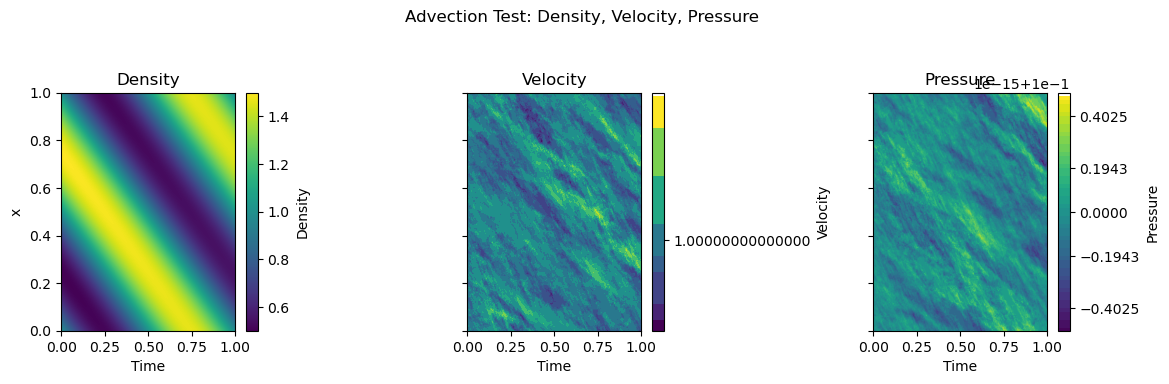

In [39]:
plot_spacetime_all_vars(Q_history, t_history, title='Advection Test: Density, Velocity, Pressure')

In the density plot we can see diagonal stripes moving downward and rightward, this is the sinusoidal density profile being carried to the right by the flow. Because the flow is periodic, the sinusoidal shape re-enters at $x=0$ and continues its path. The slope of the diagonal matches the velocity $v=1$. The wave's amplitude slightly diminishes over time $\rightarrow$ numerical diffusion.

For the velocity plot, the background should ideally be uniform at $v=1.0$ everywhere. Instead, we see small fluctuations/noise, possibly due to roundoff, plotting resolution, or residual updates during the conservative-to-primitive conversion. 

In the pressure plot, the pressure is set to be constant at $P=0.1$ and should not change. The color bar shows extremely small variations, which are most likely floating-point roundoffs. 

c) Supernova explosion

Now we are simulating a supernova explosion. For that we will simulate a blast wave with the following setup:
- Ideal monoatomic gas: $\gamma = 5/3$
- $\rho = 1.0, v=0.0, P=0.1$
- High energy density at $E=100.0/\Delta x$

For this task we will not use the periodic BC, instead we will use the Dirichlet BCs again, as we dont want the blast to re-enter the domain.

In [40]:
Np = 256  
x = np.linspace(0, 1, Np, endpoint=False)
dx = 1 / Np

rho = np.ones(Np)
v = np.zeros(Np)
P = 0.1 * np.ones(Np)

center_index = Np // 2
E_total = 100.0 / dx 
# Internal energy per unit volume: E = P / (gamma - 1)
P[center_index] = E_total * (5/3 - 1)  # Convert energy to pressure

Q_ini = np.zeros((Np, 3))
Q_ini[:, 0] = rho
Q_ini[:, 1] = v
Q_ini[:, 2] = P

In [41]:
t_end = 0.05  
Q_final, Q_history, t_history = solve_hydro1D_spacetime(Q_ini, t_end, gamma=5/3, CFLfac=0.5, store_history=True)

Step 1253, t = 0.050, dt = 0.0000
 Done in 1253 steps


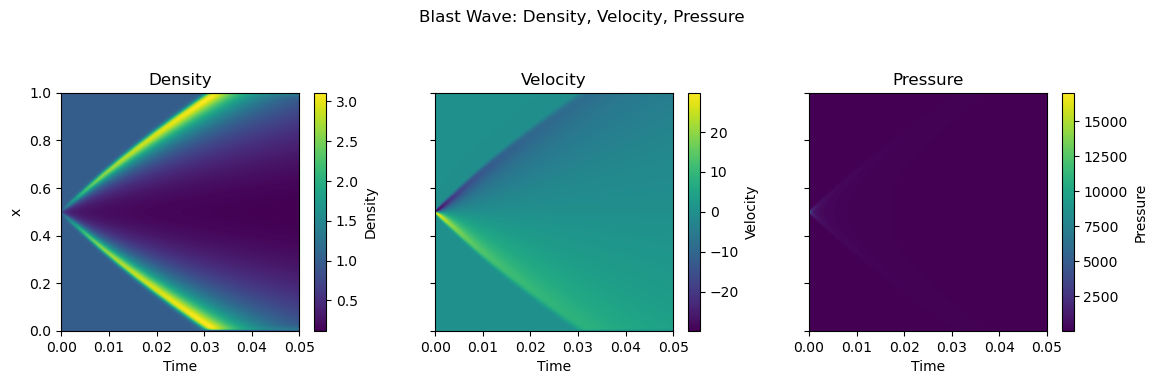

In [42]:
plot_spacetime_all_vars(Q_history, t_history, title='Blast Wave: Density, Velocity, Pressure')

In our space-time diagramm we have an initial energy spike at the center $(x=0.5, t=0)$. In the pressure plot, we see a sharp, localized region of extremely high pressure near $x=0.5$, 
immediately after  $t=0$. This corresponds to the initial energy injection in one cell. This pressure spike generates an outward force that launches a pair of strong shock waves, propagating symmetrically in both directions. All plots show V-shaped ridges moving outward in time from the center. These sharp, linear features correspond to shock fronts that compress and accelerate the material as they pass.

In the density plot, the shock front appears as a bright V-shaped ridge where the density increases abruptly. Behind the shock, the density rises above the initial uniform state. Near the center (just after the explosion), we observe a drop in density, forming a rarefaction region, where the gas is expanding and thinning out. 

In the velocity plot, we see that particles are accelerated outward from the center. The velocity peaks near the shock front, then decreases behind it. This profile shows how the gas is swept outward in a directed flow. The symmetric shape in the velocity plot reflects the symmetry of the explosion — equal propagation in both directions.

In the pressure plot, the highest pressure occurs immediately after the energy injection. This forms the initial driving force of the explosion. The shock front carries the pressure peak outward. Behind the shock, pressure remains elevated compared to the ambient value, but it gradually decreases as the energy spreads over a wider region.